This code models the dipolar interaction between fluorine atoms and muons where each muon only interacts with one fluorine atom. When I first wrote the model, I simulated each individual muon out of a sample. After realising that this simplify estimated the expected value inefficiently, and after reading the papers you sent me more properly, I then compared the results with the expected value of the wavefunction.

The model treats the forward and backwards detectors as a measurement of the muons spin along the normal axis; however, this ignores the possibility of positrons emitted from muon decay being emitted in the 'wrong' direction. The model also doesn't consider any variation in muon position in relation to the fluorine atom. Each fluorine atom is further assumed to start in the same quantum state.

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy.random import default_rng
from scipy.constants import hbar, mu_0
from matplotlib import pyplot as plt

In [2]:
FLUORINE_19_GYROMAGNETIC_RATIO = 250e6
MUON_GYROMAGNETIC_RATIO_TIMES_2_PI = 136e6
# This distance is arbitrary
DISTANCE = 0.06e-9
C = (
    mu_0 *
    FLUORINE_19_GYROMAGNETIC_RATIO *
    MUON_GYROMAGNETIC_RATIO_TIMES_2_PI / (2*DISTANCE**3)
)
MUON_MEAN_LIFETIME = 2.2e-6

In [3]:
I = np.eye(2)

S = (hbar/2)*np.array([
    [
        [0, 1],
        [1, 0]
    ],
    [
        [0, -1j],
        [1j, 0]
    ],
    [
        [1, 0],
        [0, -1],
    ]
])

up = np.array([1, 0])
down = np.array([0, 1])
projection_up = np.outer(up.conj(), up)

In [4]:
# Initialise random number generator
rng = default_rng()

In [5]:
def random_lifetime(size=None):
    return -MUON_MEAN_LIFETIME*np.log(rng.random(size))

def measure_is_spin_forward(state):
    return rng.random() < state.conj() @ np.kron(projection_up, I) @ state

In [6]:
n = np.array([1, 0, 0])
# A slightly more complicated way of getting Sx that be changed to get the spin along any normal axis n
Sn = np.tensordot(S, n, axes=(0, 0))
H = C*(sum(np.kron(S[i], S[i]) for i in range(3)) - 3*np.kron(Sn, Sn))
vals, M = eigh(H)

def U(t):
    """Time evolution operator."""
    return M @ np.diag(np.exp(vals*(-1j*t/hbar))) @ M.conj()

muon_state = down
fluorine_state = up
state = np.kron(muon_state, fluorine_state)

Since each muon is simulated individually, a extremely large sample size is needed to get decent results for some of the graphs. You can set `MUON_COUNT` to be lower if it's taking too long to run.

In [7]:
MUON_COUNT = 100000

In [8]:
forward_events = []
backward_events = []

for lifetime in random_lifetime(MUON_COUNT):
    if measure_is_spin_forward(U(lifetime) @ state):
        forward_events.append(lifetime)
    else:
        backward_events.append(lifetime)

forward_events.sort()
backward_events.sort()

In [9]:
def cumulative_forward_events(t):
    count = 0
    while count < len(forward_events) and forward_events[count] < t:
        count += 1
    return count

def cumulative_backward_events(t):
    count = 0
    while count < len(backward_events) and backward_events[count] < t:
        count += 1
    return count

def calculate_rates(bin_count, step, sorted_events):
    result = np.ndarray(bin_count)
    i = 0
    j = 0
    while i < len(sorted_events) and j < bin_count:
        count = 0
        while i < len(sorted_events) and sorted_events[i] < (j+1) * step:
            count += 1
            i += 1
        result[j] = count/step
        j += 1
    return result

step = 1e-7
ts = np.arange(0, 1e-5, step)

N_backward = calculate_rates(len(ts), step, backward_events)
N_forward = calculate_rates(len(ts), step, forward_events)
A = (N_backward-N_forward) / (N_backward+N_forward)
G = A/np.max(A)

In [10]:
sigma_z = np.array([
    [1, 0],
    [0, -1]
])

def D(state):
    """Expected polarisation."""
    return state.conj() @ np.kron(sigma_z, I) @ state

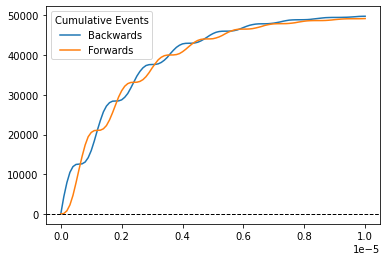

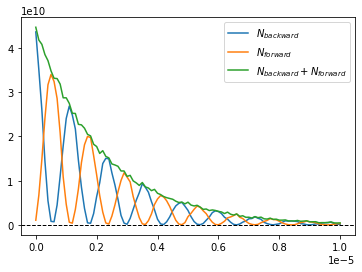

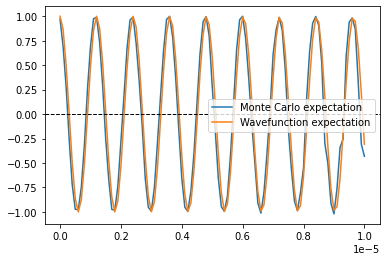

In [11]:
plt.plot(ts, [cumulative_backward_events(t) for t in ts], label='Backwards')
plt.plot(ts, [cumulative_forward_events(t) for t in ts], label='Forwards')
plt.legend(title='Cumulative Events')
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.show()

plt.plot(ts, N_backward, label='$N_{backward}$')
plt.plot(ts, N_forward, label='$N_{forward}$')
plt.plot(ts, N_backward+N_forward, label='$N_{backward}+N_{forward}$')
plt.legend()
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.show()

plt.plot(ts, G, label='Monte Carlo expectation')
plt.plot(ts, np.array([-D(U(t) @ state) for t in ts]).real, label='Wavefunction expectation')
plt.legend()
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.show()